Aaron FARGEON  
Julien KHLAUT  
Pierre-Louis RUHLMANN

# PROJECT 3 : PERFORMANCE OF THE LASSO IN HIGH-DEMENSIONAL LINEAR REGRESSION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

We consider a linear model where one observes iid observations $$y_i = x_i^T \beta^* + \varepsilon_i$$ where $x_i$ has iid $\mathcal{N}(0,1)$ entries and $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$. The goal is to study the performance of the Lasso

\begin{equation}
    \tag{L}
    \hat{\beta} = \underset{b \in \mathbb{R}^p}{\text{argmin}} \frac{1}{n} \sum\limits_{i=1}^n \frac{(y_i - x_i^T b)^2}{2} + n^{-\frac{1}{2}} \lambda \vert \vert b \vert \vert_1
\end{equation}

where $\lambda > 0$ is a tuning parameter.

We focus on the situation where if $p, n$ are high but of the same order, i.e. $\frac{n}{p} = \delta$ (or $\frac{p}{n} \rightarrow \delta$) for some constant $\delta > 0$ independent of $n,p$. We will also assume that for each $n,p$, the true $\beta^*$ is such that $\beta^*_j = \frac{\Theta_j}{\sqrt{p}}$ where $\Theta_1,...,\Theta_p$ are iid random variables of the form $\Theta_j=r_j B_j$ where $Bj$ has the Bernoulli distribution with parameter 0.128 and $r_j \in \{\pm1\}$ is a random sign independent of $B_j$ with $\mathbb{E}[r_j] = 0$. The true parameter $\beta^*$ is thus “sparse” in the sense that, approximately, only 12.8 percent of coordinates are nonzero.

#### First task  
Set $\delta = 0.64$ and $\sigma^2 = 0.2$. For each tuning parameter $\lambda$ on a grid of equispaced points in $[0,2.5]$, compute 10 different datasets with $p= 400$, $n=p \delta$, design matrix $X$ with iid entries, $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$, $\beta^* \in \mathbb{R}^p$ generated with iid components $\frac{\Theta_j}{\sqrt{p}}$ as  explained above, and for each dataset compute the  estimator $\hat{\beta}$ in $(\text{L})$ and report its performance $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$ in boxplots where the $x$-axis represents $\lambda$ and the $y$-axis $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$. You can for instance use seaborn’s boxplot. If your computer is sufficiently powerful, plot similar boxplots with $p = 600$ and/or $p= 800$ with always $n=p \delta$, $\delta= 0.64$.

In [34]:
def lasso(b, y, X, n, l):
    return np.mean((y - np.dot(X.T, b))**2 / 2) + (l * np.linalg.norm(b, ord = 1)) / np.sqrt(n)
    

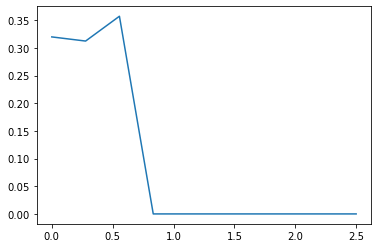

In [43]:
delta = 0.64
sigma2 = 0.2

grid = np.linspace(0, 2.5, 10)

p = 400
n = int(p * delta)

diff = []

for l in grid:
    
    for i in range(n):
        x = np.random.normal(0, 1, size = (p,1))
        if i == 0:
            X = x
        else:
            X = np.concatenate((X,x), axis = 1)
            
    epsilon = np.random.normal(0, sigma2, size = (n,1))
    
    beta_star = np.zeros((p,1))
    for j in range(p):
        rj = np.random.choice(np.array([-1, 1]))
        Bj = np.random.binomial(1, 0.128)
        beta_star[j,0] = (rj * Bj) / np.sqrt(p)
    
    y = np.dot(X.T, beta_star) + epsilon
    
    def lasso_l(b):
        return lasso(b, y, X, n, l)
    
    beta_star = np.array([beta_star[j,0] for j in range(p)])
    beta_hat = opt.minimize(lasso_l, beta_star)
    
    diff.append(np.linalg.norm(beta_hat.x - beta_star))

plt.plot(grid, diff)


#### A system of two linear equations  \n
Throughout, $Z \sim \mathcal{N}(0,\sigma^2)$ is a random variable independent of $\Theta$ and $\Theta$ has the same distributionas $\Theta_1,...,\Theta_p$. Your next task is to compute numerically solutions $\tau^*, b^*$ to the system of equations $$\begin{cases} \tau^2 = \sigma^2 + \frac{1}{\delta} \mathbb{E}[(\eta(\Theta + \tau Z, \frac{\tau \lambda}{b}) - \Theta)^2] \\ b = \tau (1 - \frac{1}{\delta} \mathbb{E}[\eta'(\Theta + \tau Z, \frac{\tau \lambda}{b})]) \end{cases}$$ with unknown $(\tau,b)$; here the function $\eta(u,t)$ for $u \in \mathbb{R}$ and $t \geq 0$ is given by $\eta(u,t) = \text{sign}(u) \text{max}(\vert u \vert − t,0)$. Note that the solutions $(\tau^*, b^*)$ implicitly depend on $(\lambda, \delta)$ and the distribution of $\Theta$. Changing the values of $\lambda, \delta$ modifies the values of $(\tau^*, b^*)$ although the dependence in $(\lambda, \delta)$ is implicit. To solve the above system for various values of $\lambda$, it is convenient to instead consider a parameter $\alpha >0$ such that $\alpha = \frac{\lambda}{b}$, so that the second argument of $\eta$ and $\eta'$ in the above system is reduced to $\tau \alpha$. For a given $\alpha$, the goal is to first compute a solution $\tau^*(\alpha)$ of the equation

\begin{equation}
    \tag{1}
    \tau^2 = \sigma^2 + \frac{1}{\delta} \mathbb{E}[(\eta(\Theta + \tau Z, \tau \alpha) - \Theta)^2]
\end{equation}

with unknown $\tau$. From this solution $\tau^*(\alpha)$, define  $b^*(\alpha)$ using the second equation, i.e.

\begin{equation}
    \tag{2}
    b^* (\alpha) = \tau^* (\alpha) (1 - \frac{1}{\delta} \mathbb{E}[\eta'(\Theta + \tau^* (\alpha) Z, \alpha \tau^* (\alpha))])
\end{equation}

and finally get back the correspondence between $\alpha$ and $\lambda$ by $\lambda (\alpha)$ = $\alpha b^* (\alpha)$.

#### Second task

#### Question 1  
Plot the function $u \mapsto \eta(u,t)$ for $t = 1,2,3$.

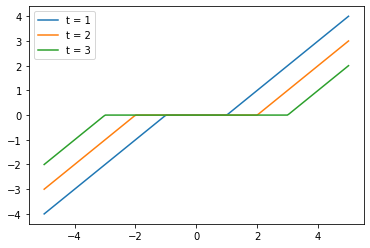

In [7]:
def eta(u,t):
    return np.sign(u) * max(abs(u) - t, 0)

plt.figure()
U = list(np.linspace(-5,5,200))
for t in [1,2,3]:
    plt.plot(U, [eta(u,t) for u in U], label = "t = " + str(t))
plt.legend()
plt.show()

#### Question 2  
What is the almost everywhere derivative of $u \mapsto \eta(u,t)$ ?

##### Answer :
It is : $$\begin{cases} \begin{array}{cl} 1 & \text{if $\vert u \vert - t > 0$} \\ 1 & \text{if $\vert u \vert - t < 0$} \end{array} \end{cases}$$

#### Question 3  
Using integration by parts, rewrite the system of nonlinear
equations to remove the expectations, using the standard normal probability density function $\phi(u) = \sqrt{2 \pi}^{−1} e{−\frac{u^2}{2}}$ and cumulative distribution function $\Phi(u) = \int_{- \infty} ^u \phi(v) \text{d}v$ (hint:
you may check your calculations by comparing your expression for equation $(1)$ to the value of $F_\alpha (\tau^2)$ given in the first few lines of the proof of lemma A.5 in https://arxiv.org/abs/1811.01212).

#### Question 4  
Propose an iterative scheme of the form $\tau_t = F_{\alpha, \delta} (\tau_{t-1})$ such that $\tau^*(\alpha)$ is a solution to $(1)$ if and only if it is a fixed point of $F_{\alpha, \delta}$.

#### Question 5  
For given $(\alpha, \lambda)$, implement in Python this numerical scheme to compute approximate $\tau^*(\alpha)$, and once $\tau^*$ is computed, im- plement the computation of $b^*(\alpha)$ and $\lambda^*(\alpha)$. You can access optimized code to compute $\phi$ and $\Phi$ in scipy.stats.norm.pdf and .cdf respectively.

In [2]:
from random import randint
import scipy.stats
phi = scipy.stats.norm.pdf
Phi = scipy.stats.norm.cdf

def solve_implement(F, alpha, delta, nb, tho_0, eps):
    tho_1 = tho_0
    tho_2 = F(alpha, delta, tho_0, nb)
    while abs(tho_1 - tho_2) > eps:
        tho_1 = tho_2
        tho_2 = F(alpha, delta, tho_1, nb)
    return tho_1

def F(alpha, delta, tho, nb):
    return ((1+alpha**2)/delta)* Esp(tho, alpha, delta, nb)

def Theta():
    r = np.random.choice(np.array([-1, 1]))
    B = np.random.binomial(1, 0.128)
    return B*r

def Esp(tho, alpha, delta, nb):
    M = 0
    for i in range(nb):
        x = Theta() / tho
        M += (x**2 - alpha**2 - 1)*(Phi(x - alpha) - Phi(-alpha - x)) - (x + alpha)*phi(alpha - x) + (x - alpha)*phi(x + alpha)  
    M /= nb
    return M

def compute_b(tho, delta, alpha):
    return tho*(1 - (2*(1-0.128)*(1-Phi(alpha*tho))+0.128*(1-Phi(tho*alpha-1))+0.128*(tho*alpha+1))/delta)

def compute_lambda(b, alpha):
    return b*alpha

tho_0 = 0.2 + 1/(2*0.64)
print(solve_implement(F, 1, 0.64, 100, tho_0, 1e-1))

-1.5561663757175646


#### Question 6  
Set $\delta = 0.64$ and $\sigma^2 = 0.2$. For a grid of $\alpha$’s equispaced in an interval of the form $[0,t]$, plot the curves (a) $(\alpha, \tau^*(\alpha))$, (b) $(\alpha, b^*(\alpha))$, (c) $(\alpha, \lambda(\alpha))$ and finally (d) $(\lambda(\alpha), \delta(\tau^∗(\alpha)^2 − \sigma^2)$. Compare curve (d) with Figure 6 in the paper *The LASSO risk for gaussian matrices* by Bayati and Montanari (2011); the curves should coincide for these values of $\delta$ and $\sigma$.

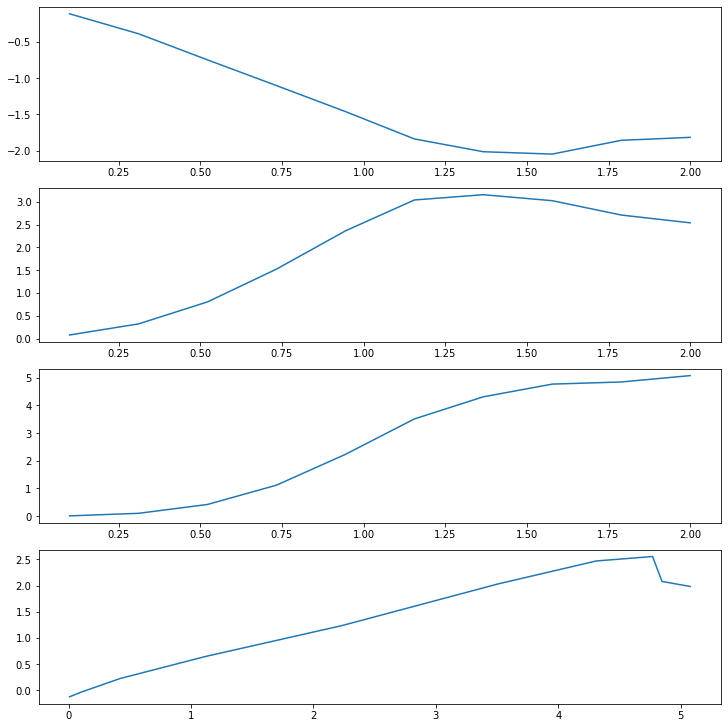

In [8]:
delta = 0.64
sigma2 = 0.2
alpha = np.linspace(0.1, 2, 10)
Tho = []
Tho_square = []
B = []
Lambda = []

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(10, 10))

for a in alpha:
    tho = solve_implement(F, a, delta, 100, sigma2 + 1/(2*delta), 1e-2)
    Tho.append(tho)
    Tho_square.append(delta*(tho**2-sigma2))
    b = compute_b(tho, delta, a)
    B.append(b)
    l = compute_lambda(b, a)
    Lambda.append(l)

axs[0].plot(alpha, Tho)
axs[1].plot(alpha, B)
axs[2].plot(alpha, Lambda)
axs[3].plot(Lambda, (Tho_square))

#### Question 7  
Now compare curve (d) of the previous question to the boxplots of the performance of the Lasso. Combine the theoretical curve $(\lambda(\alpha), \delta(\tau^∗(\alpha)^2 − \sigma^2))$ on the same plot as the experimental boxplots and verity that the theoretical curve correctly predicts the experimental performance in the boxplots. Try different values of $\sigma^2, \delta$ (say, 3 different other combinations) and observe whether the theoretical curve correctly predicts the experimental performance in the boxplots.

#### Question 8  
Compare the previous iterative scheme $\tau_t = F_{\alpha, \delta} (\tau_{t-1})$ this with another idea to compute $\tau^*(\alpha)$, which consists, at each step t, of replacing the expectation in the right hand side of the system by averages over 100 000 independent copies of $(\Theta,Z)$. (Use 100 000 fresh independent copies at each iteration $t$). Do the two implementations coincide ? You may change the value 100 000 to a smaller/larger one depending on the power of your laptop.